# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown
import os
import gdown
import zipfile


output_dir = os.path.join("data", "phase2")
if not os.path.exists(output_dir):  # Check if the directory already exists
    os.makedirs(output_dir)  # Create the directory if it doesn't exist

# Download the train dataset
download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = os.path.join(output_dir, "dlav_train.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "train")):  # Check if the directory already exists    
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the validation dataset
download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = os.path.join(output_dir, "dlav_val.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "val")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the test dataset
download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = os.path.join(output_dir, "dlav_test_public.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "test_public")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [2]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth
            }

## Data Augmentation

In [22]:
import os
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm

def augment_and_save(file_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    for file_path in tqdm(file_list):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Flip image horizontally
        camera = data['camera'][:, ::-1, :]  # shape HxWxC, flip width
        depth = data['depth'][:, ::-1, :]
        
        # Flip signs for 2nd and 3rd cols in history and future
        data['camera'] = camera
        data['depth'] = depth
        data['sdc_history_feature'][:, 1:] *= -1

        if 'sdc_future_feature' in data:
            data['sdc_future_feature'][:, 1:] *= -1

        # Save to new file
        base = os.path.basename(file_path)
        new_path = os.path.join(save_dir, f"flipped_{base}")
        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

augmented_train_path = os.path.join("data", "phase2", "augmented_train")
if not os.path.exists(augmented_train_path):
    train_data_dir = os.path.join("data", "phase2", "train")
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    augmented_train = augment_and_save(train_files, save_dir=augmented_train_path)
else:
    print("Augmented training data already exists. Skipping augmentation.")

Augmented training data already exists. Skipping augmentation.


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

## Planners

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Baseline planner for driving prediction
class DrivingPlanner(nn.Module):
    def __init__(self, use_depth_aux=False):
        super().__init__()
        self.use_depth_aux = use_depth_aux

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )

        self.cnn_flatten = nn.Flatten()


        # Decoder for trajectory prediction
        self.decoder = nn.Linear((32 * 100 * 150) + (21 * 3), 60 * 3)

        # Optional depth decoder
        if self.use_depth_aux:
            self.depth_decoder = nn.Sequential(
                nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # Upsample
                nn.ReLU(),
                nn.Conv2d(16, 1, kernel_size=3, padding=1),
                nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)
            )

    def forward(self, camera, history):
        B = camera.size(0)

        # Process camera
        cnn_feat = self.cnn_backbone(camera)         # (B, 32, 100, 150)
        feat_flat = self.cnn_flatten(cnn_feat)       # (B, 32*100*150)


        # Flatten history
        history_flat = history.view(B, -1)

        # Concatenate and decode trajectory
        combined = torch.cat([feat_flat, history_flat], dim=1)
        future = self.decoder(combined).view(B, 60, 3)

        # Optional depth map prediction
        depth_out = None
        if self.use_depth_aux:
            depth_out = self.depth_decoder(cnn_feat.detach()).permute(0, 2, 3, 1)

        return future, depth_out


In [264]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import pytorch_lightning as pl
import os
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything


class SharedEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Output: B x 512 x H/32 x W/32

    def forward(self, x):
        return self.encoder(x)


class DepthDecoder(nn.Module):
    def __init__(self, in_channels=512, output_size=(200, 300)):
        super().__init__()
        self.output_size = output_size
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )
    def forward(self, x):
        # Initial upsampling through the network
        x = self.upsample(x)  
        # Final resize to match ground truth dimensions
        return F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)


class HistoryEncoder(nn.Module):
    def __init__(self, seq_len=21, feat_dim=2, hidden_dim=128): # changed the dimenstion to 2 instead of 3
        super().__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        
        self.fc = nn.Sequential(
            nn.Linear(seq_len * feat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
            nn.ReLU()
        )

    def forward(self, history):
        # history: B x T x 2
        batch_size = history.size(0)
        # Flatten the temporal dimension
        history_flat = history.reshape(batch_size, -1)  # B x (T*3)
        return self.fc(history_flat)  # B x hidden_dim


class MultiModalMultiTaskModel(nn.Module):
    def __init__(self, num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300)):
        super().__init__()
        self.num_modes = num_modes
        self.pred_len = pred_len
        
        # Visual encoder
        self.image_encoder = SharedEncoder()
        self.depth_decoder = DepthDecoder(in_channels=512, output_size=depth_output_size)
        
        # History encoder
        self.hist_encoder = HistoryEncoder(seq_len=hist_seq_len, feat_dim=hist_feat_dim, hidden_dim=128)
        
        # Fusion layer with batch normlization
        self.fusion = nn.Sequential(
            nn.Linear(512 + 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Trajectory decoder - predict multiple modes
        self.traj_decoder = nn.Linear(512, num_modes * pred_len * 2)  # Predict x,y coordinates for each mode
        
        # Confidence scores for each mode
        self.confidence_decoder = nn.Linear(512, num_modes)

    def forward(self, img, hist):
        # Encode image
        img_feat = self.image_encoder(img)
        depth_pred = self.depth_decoder(img_feat)
        
        # Encode history
        hist_feat = self.hist_encoder(hist)
        
        # Combine features
        combined = torch.cat([img_feat.mean(dim=[2,3]), hist_feat], dim=1)
        
        # Fusion layer
        fused = self.fusion(combined)
        
        # Decode trajectories and confidence scores
        traj_pred = self.traj_decoder(fused)
        traj_pred = traj_pred.view(-1, self.num_modes, self.pred_len, 2)  # B x M x T x 2
        
        # Predict confidence scores
        conf_pred = self.confidence_decoder(fused)
        conf_pred = F.softmax(conf_pred, dim=1)  # Normalize to probabilities
        
        # Select best trajectory based on confidence
        best_mode = torch.argmax(conf_pred, dim=1)  # B
        best_traj = torch.gather(traj_pred, 1, 
                              best_mode.view(-1, 1, 1, 1).expand(-1, 1, self.pred_len, 2))
        best_traj = best_traj.squeeze(1)  # B x T x 2
        
        return depth_pred, traj_pred, conf_pred, best_traj

def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading = False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error
    
    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)
        
    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only x, y coordinates from ground truth if needed
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]
    
    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]
    
    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B] - Use highest confidence
    else:
        # Fall back to minimum ADE if no confidences provided
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]
    
    # Get errors for best mode per batch element
    batch_indices = torch.arange(pred_trajectories.size(0), device=pred_trajectories.device)
    best_mode_error = error_per_mode[batch_indices, best_mode_idx]  # [B, T]
    
    # Compute metrics
    ade = best_mode_error.mean().item()
    fde = best_mode_error[:, -1].mean().item()
    
    return ade, fde

### Custom Loss Function for Depth

In [265]:

def weighted_smooth_l1_loss(pred, target, beta=0.8, focus_range=(75, 150), importance=0.75):
    """
    pred, target: shape [B, C, H, W]
    focus_range: (start_height, end_height)
    importance: proportion of total loss weight to give to this region
    beta: threshold for smooth L1 loss
    """
    B, C, H, W = pred.shape
    device = pred.device

    # Step 1: Smooth L1 loss without reduction
    diff = pred - target
    abs_diff = torch.abs(diff)
    loss = torch.where(abs_diff < beta, 0.5 * (diff ** 2) / beta, abs_diff - 0.5 * beta)

    # Step 2: Create a height-weight mask
    weights = torch.ones((1, 1, H, 1), device=device)  # [1, 1, H, 1]

    # Assign weights
    low, high = focus_range

    weights[:, :, :low, :] = (1 - importance) * H/(high-low)  # top (sky)
    weights[:, :, low:high, :] = importance * H/(high-low)    # middle (main focus)
    weights[:, :, high:, :] = (1 - importance) * H/(high-low) # bottom (ground)

    # Broadcast weights to [B, C, H, W]
    weights = weights.expand_as(loss)

    # Step 3: Apply weights and reduce
    weighted_loss = loss * weights
    return weighted_loss.mean()

In [ ]:
# Lightning
from pytorch_lightning import LightningModule

class LightningDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, scheduler_patience=5, 
                 max_pred_len=60, num_modes=4, curriculum_epochs=20, grad_clip=7.0, depth_mask=None, depth_k = 0.1, beta=1
                 ):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.max_pred_len = max_pred_len
        self.curriculum_epochs = curriculum_epochs
        self.grad_clip = grad_clip
        self.model = MultiModalMultiTaskModel(num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300))
        self.depth_mask = depth_mask
        self.scheduler_patience = scheduler_patience
        self.depth_k = depth_k
        self.beta = beta
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Patience: {self.scheduler_patience}")
        print(f"depth_k: {self.depth_k}")
        print(f"Mask depth: {depth_mask is not None}\n")
        print(f"Smooth L1 Loss Beta: {self.beta}")
        
    
    def forward(self, camera, history):
        history= history[:, :, :2] # [B, T, 2]
        return self.model(camera, history)
    
    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        depth_gt = batch['depth'].permute(0, 3, 1, 2)          # [B, 200, 300, 1]
        
        # Get current epoch
        current_epoch = self.current_epoch
        
        # Curriculum learning: gradually increase prediction horizon
        if current_epoch < self.curriculum_epochs:
            pred_len = int((current_epoch / self.curriculum_epochs) * self.max_pred_len) + 1
        else:
            pred_len = self.max_pred_len
            

        depth_pred, traj_pred, conf_pred, best_traj = self(camera, history)
        # Truncate predictions and ground truth
        best_traj = best_traj[:, :pred_len]
        future = future[:, :pred_len]
        
        if self.depth_mask is not None:
            self.depth_mask = self.depth_mask.to(depth_gt.device)
            depth_gt = torch.clamp(self.depth_mask.to(depth_gt.device) - depth_gt, min=0)
        # Compute losses
        depth_loss = nn.SmoothL1Loss(beta=self.beta)(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss(beta=self.beta)(best_traj, future[:, :, :2])
        
        # Combine losses with weighted sum
        loss =  self.depth_k * depth_loss + traj_loss
        
        # Gradient clipping
        self.clip_gradients(self.trainer.optimizers[0], gradient_clip_val=self.grad_clip)
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_depth_loss', depth_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_traj_loss', traj_loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss

        

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        depth_gt = batch['depth']

        # Forward pass
        depth_pred, traj_pred, conf_pred, best_traj = self(camera, history)
        depth_gt = depth_gt.permute(0, 3, 1, 2)

        
        if self.depth_mask is not None:
            self.depth_mask = self.depth_mask.to(depth_gt.device)
            depth_gt = torch.clamp(self.depth_mask.to(depth_gt.device) - depth_gt, min=0)
        # Compute losses
        depth_loss = nn.SmoothL1Loss(beta=self.beta)(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss(beta=self.beta)(best_traj, future[:, :, :2])
        loss = self.depth_k * depth_loss + traj_loss
        
        # Compute ADE and FDE
        ade, fde = compute_ade_fde(traj_pred, future)

        # Log validation metrics
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_depth_loss', depth_loss, prog_bar=True, sync_dist=True)
        self.log('val_traj_loss', traj_loss, prog_bar=True, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)

        return {'val_loss': loss, 'val_depth_loss': depth_loss, 'val_traj_loss': traj_loss, 'val_ade': ade, 'val_fde': fde}

    def test_step(self, batch, batch_idx):
        # dont't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        # Use AdamW optimizer with better weight decay handling
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler with cosine annealing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.epochs,
            eta_min=1e-6
        )
        
        # Early stopping callback
        early_stopping = pl.callbacks.EarlyStopping(
            monitor='val_ade',
            min_delta=0.0001,
            patience=10,
            verbose=True,
            mode='min'
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            },
            'callbacks': [early_stopping]
        }

## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [267]:

def compute_depth_mask_from_loader(loader, max_samples=None):
    total = None
    count = 0

    for i, sample in enumerate(loader.dataset):
        depth = sample['depth']  # shape: [H, W, 1] — NHWC
        right_column = depth[:, -1, :]  # shape: [H, 1]

        right_column = torch.tensor(right_column, dtype=torch.float32)

        if total is None:
            total = right_column
        else:
            total += right_column

        count += 1
        if max_samples is not None and count >= max_samples:
            break

    avg_column = total / count  # shape: [H, 1]

    # Reshape to [1, 1, H, W] for depth subtraction
    depth_mask = avg_column.unsqueeze(0).unsqueeze(0)  # [1, 1, H, 1]
    depth_mask = depth_mask.expand(-1, -1, -1, loader.dataset[0]['depth'].shape[1])  # W = width

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.imshow(depth_mask.squeeze(0).squeeze(0).cpu().numpy(), cmap='viridis')
    plt.title("Depth Mask")
    plt.axis('off')
    plt.show()
    return depth_mask

In [ ]:
import random        
# Training function
def run_experiment( max_epochs=50, batch_size=32, lr=1e-4, weight_decay=2.6551e-6, scheduler_patience=5, beta = 1,
                   augment_train=True, augment_val=False, seed=42, logger_name='multitask_driving_planner', mask_depth=False, depth_k = 0.1):
    # Set random seed for reproducibility
    pl.seed_everything(seed)

    # Define paths to data
    train_data_dir = os.path.join("data", "phase2", "train")
    val_data_dir = os.path.join("data", "phase2", "val")
    augmented_train_data_dir = os.path.join("data", "phase2", "augmented_train")

    # Get file lists
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

    augmented_train_files = [os.path.join(augmented_train_data_dir, f) for f in os.listdir(augmented_train_data_dir) if f.endswith('.pkl')]
    
    if augment_train:
        all_train_files = train_files + augmented_train_files
        random.Random(42).shuffle(all_train_files)
        train_dataset = DrivingDataset(all_train_files)
        print("length of train dataset ", len(all_train_files))
        
    else:
        train_dataset = DrivingDataset(train_files)

    if augment_val:
        val_dataset = DrivingDataset(val_files)
    else:
        val_dataset = DrivingDataset(val_files)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        pin_memory=True
    )

    depth_mask = None
    if mask_depth:
        depth_mask = compute_depth_mask_from_loader(train_loader, max_samples=1000)

    # Initialize model with Lightning wrapper
    model = LightningDrivingPlanner(
        lr=lr, 
        weight_decay=weight_decay, 
        epochs=max_epochs, 
        scheduler_patience=scheduler_patience,
        depth_mask=depth_mask,  # pass the depth mask to the model
        depth_k=depth_k,  # pass the depth k to the model
        beta=beta
    )
    logger_path = os.path.join("lightning_logs", "phase2")
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)
    # Initialize logger
    logger = TensorBoardLogger(save_dir=logger_path, name=logger_name)
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # Setup checkpoint callback
    # get logger version
    version = logger.version
    # get the current time for unique checkpoint names
    filename = f"driving_planner_version_{version}"
    print(f"Model version: {version}\n====================================\n ")
    # create a directory for the checkpoints

    checkpoint_path = os.path.join("checkpoints", "phase2")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_dir = os.path.join(checkpoint_path, logger_name)
    # Checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename= filename + '_{epoch:02d}_{val_ade:.4f}',
        monitor='val_ade',
        mode='min',
        save_top_k=2,
        save_last=True,
        verbose=True
    )

    # Create trainer with limited epochs for quick overfitting test
    trainer = pl.Trainer(
        max_epochs=max_epochs, 
        logger=logger,
        accelerator='auto',  # Automatically select GPU if available
        devices='auto',
        precision=16,  # Use mixed precision
        log_every_n_steps=5,  # Logging freq
        gradient_clip_val=7.0,
        enable_checkpointing=True,  
        callbacks=[checkpoint_callback, lr_monitor],
  
    )

    # Train on the small dataset
    trainer.fit(model, train_loader, val_loader)
    # return best model and validation loader for testing
    best_model_path = checkpoint_callback.best_model_path
    best_model_val_loss = checkpoint_callback.best_model_score
    print(f"Best model val_loss: {best_model_val_loss}\nBest model path: {best_model_path}")
    # Load the best model
    model = LightningDrivingPlanner.load_from_checkpoint(best_model_path)

    # Test the model on the validation set again to be sure
    model.eval()
    trainer.validate(model, val_loader)
    return model, val_loader, best_model_val_loss


Seed set to 42
C:\Users\Mert\AppData\Local\Temp\ipykernel_952\3315642469.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  right_column = torch.tensor(right_column, dtype=torch.float32)


length of train dataset  10000


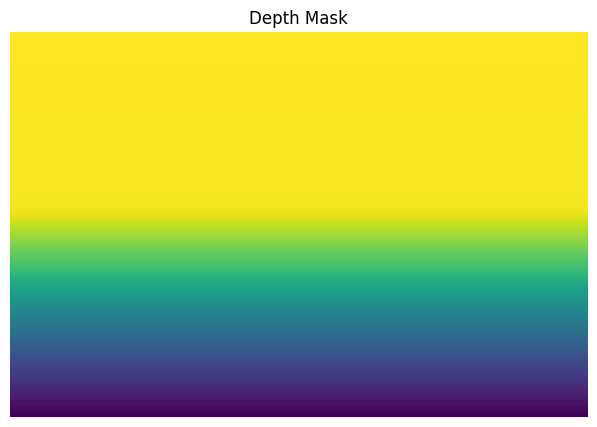

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 13.7 M | train
-----------------------------------------------------------
13.7 M    Trainable params
0         Non-trainable params
13.7 M    Total params
54.940    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode



Model initialized with parameters:
Learning Rate: 0.0001
Weight Decay: 2.6551e-06
Number of Epochs: 100
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.1
Mask depth: True

Model version: 21
 
                                                                           

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:  39%|███▊      | 121/313 [00:05<00:09, 20.61it/s, v_num=21, train_loss_step=0.0881, train_depth_loss_step=0.453, train_traj_loss_step=0.0428]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=True, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [243]:
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model, device):
    model.eval()
    #model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    with torch.no_grad():
        #pred_no_aux, _ = model_no_aux(camera, history)
        #pred_with_aux, pred_depth = model_with_aux(camera, history)
        depth_pred, traj_pred, conf_pred, best_traj = model(camera, history)
        # Truncate predictions and ground truth
        pred_depth = depth_pred.permute(0, 2, 3, 1)  # shape: [B, H, W, 1] (torch, GPU)

        if hasattr(model, 'depth_mask') and model.depth_mask is not None:
            pred_depth = model.depth_mask.squeeze(0).squeeze(0).unsqueeze(-1).to(pred_depth.device) - pred_depth

        pred_with_aux= best_traj

        

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # With aux
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], '.-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("With Depth Aux")
        ax[i].axis("equal")
 
    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    return future, pred_with_aux, depth, pred_depth



Depth range:  tensor(204.) tensor(254.)


Text(0.5, 1.0, 'GT Depth')

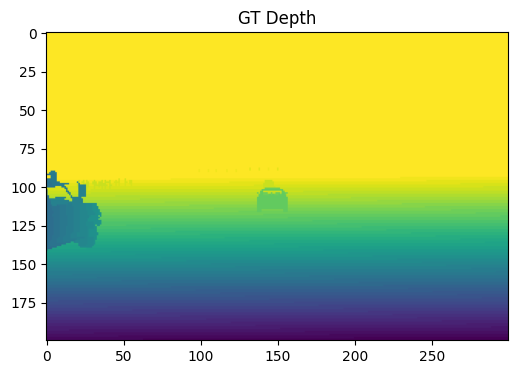

In [244]:
#plot depth train_loader.dataset[0]["depth"]
print("Depth range: ", val_loader.dataset[0]["depth"].min(), val_loader.dataset[1]["depth"].max())
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(val_loader.dataset[0]["depth"][:, :, 0])
ax.set_title("GT Depth")

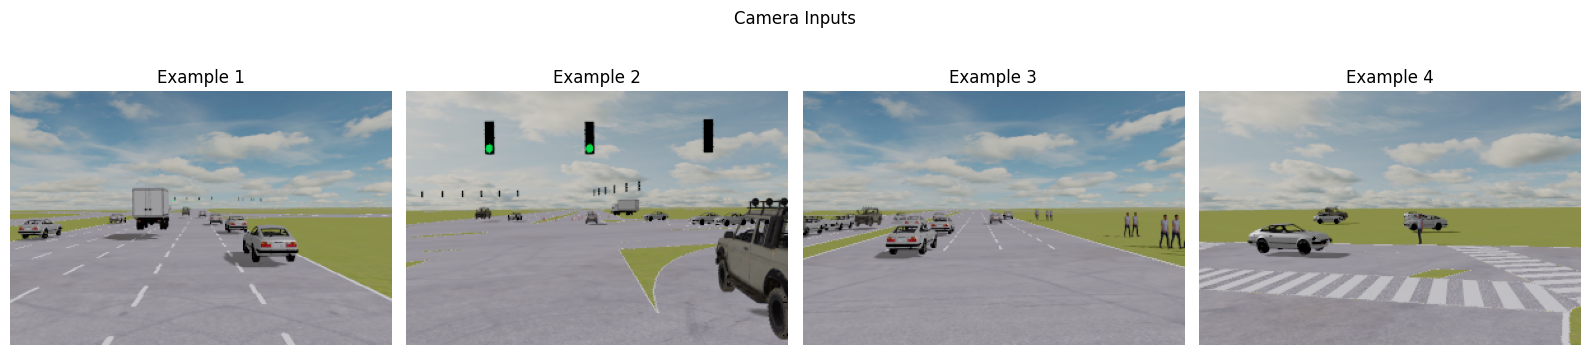

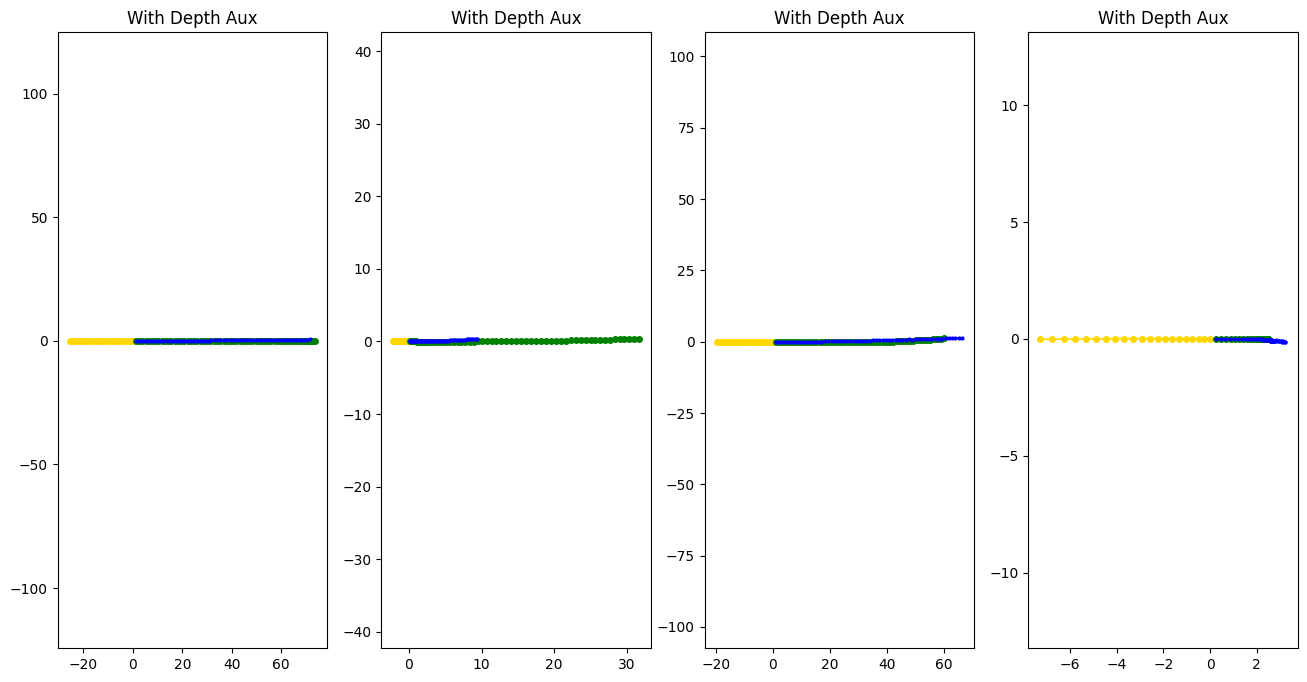

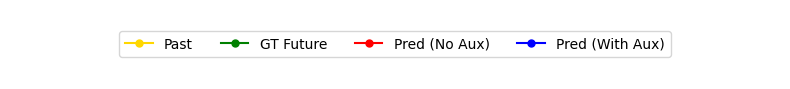

<Figure size 640x480 with 0 Axes>

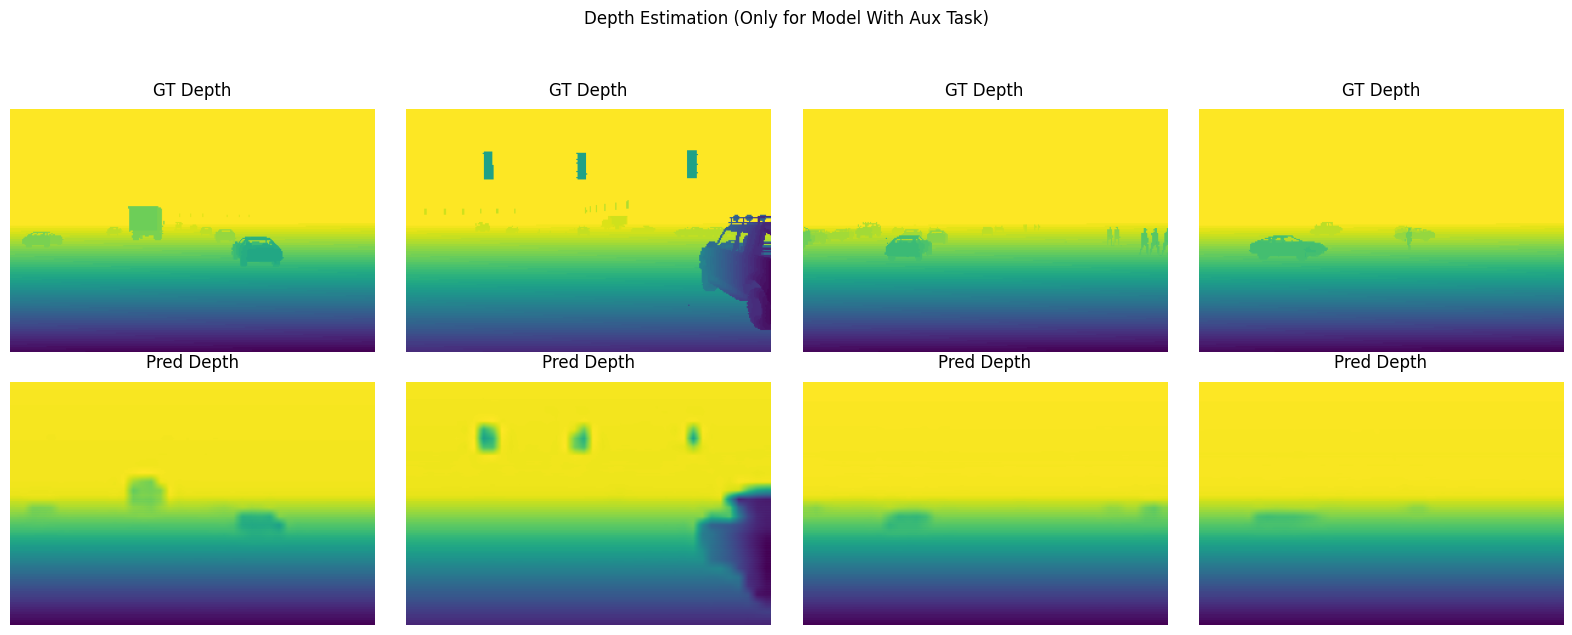

In [252]:
# checkpoint = "driving_planner_version_5_epoch=35_val_ade=1.3833.ckpt"
# checkpoint_path = os.path.join("checkpoints", "phase2", "multitask_driving_planner", checkpoint)
# model = LightningDrivingPlanner.load_from_checkpoint(checkpoint_path)
# Call at the end after training 
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
import optuna

study_name = "fine_optuna_trial_with_heading_old_loss"

def objective(trial):
    # Define the hyperparameter search space
    num_nodes = trial.suggest_int("num_nodes", 4, 6)
    max_epochs = trial.suggest_int("max_epochs", 60, 120)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 5e-5)
    scheduler_patience = trial.suggest_int("scheduler_patience", 2, 10)
    lr = trial.suggest_loguniform("lr", 5e-5, 1e-3)
    mask_depth = trial.suggest_categorical("mask_depth", [True, False])
    # Run your experiment
    model, val_loader, best_model_val_ade = run_experiment(
        lr=lr,
        num_nodes=num_nodes,
        max_epochs=max_epochs,
        weight_decay=weight_decay,
        scheduler_patience=scheduler_patience,
        augment_train=True,
        logger_name=study_name
    )

    # The score Optuna will try to minimize or maximize
    return best_model_val_ade  

# Create the Optuna study
study = optuna.create_study(direction="minimize")  # or "minimize" depending on your metric
study.optimize(objective,  n_trials=10)

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=True, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=False, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=True, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=True, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=True, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=True, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=100, mask_depth=True, depth_k=0.1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [8]:
use_depth_aux=True
model_with_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=50,use_depth_aux=use_depth_aux, lambda_depth=0.05)

Using device: cuda
Epoch 1, Loss: 142.2556, Validation - ADE: 6.4023, FDE: 14.9054, Traj MSE: 25.539502
Epoch 2, Loss: 27.5315, Validation - ADE: 4.1872, FDE: 10.4015, Traj MSE: 12.954754
Epoch 3, Loss: 19.2958, Validation - ADE: 3.8105, FDE: 9.5973, Traj MSE: 11.364632
Epoch 4, Loss: 14.1365, Validation - ADE: 3.6788, FDE: 9.1150, Traj MSE: 10.562031
Epoch 5, Loss: 10.0951, Validation - ADE: 3.8009, FDE: 9.0157, Traj MSE: 10.709022
Epoch 6, Loss: 8.3360, Validation - ADE: 3.6973, FDE: 8.9875, Traj MSE: 10.401710
Epoch 7, Loss: 7.2799, Validation - ADE: 3.7196, FDE: 8.9284, Traj MSE: 10.403030
Epoch 8, Loss: 6.2438, Validation - ADE: 3.8202, FDE: 9.0623, Traj MSE: 10.804030
Epoch 9, Loss: 5.4324, Validation - ADE: 3.8956, FDE: 9.1289, Traj MSE: 10.995228
Epoch 10, Loss: 4.7716, Validation - ADE: 3.8556, FDE: 9.0189, Traj MSE: 10.895271
Epoch 11, Loss: 4.3220, Validation - ADE: 3.9295, FDE: 9.1769, Traj MSE: 11.258259
Epoch 12, Loss: 3.8521, Validation - ADE: 3.8436, FDE: 9.0227, Traj M

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ade, fde, mse = validate(model_no_aux, val_loader, device)
print(f"Validation results for model without depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

ade, fde, mse = validate(model_with_aux, val_loader, device)
print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

Validation results for model without depth auxiliary loss: ADE: 4.0365, FDE: 9.7488, Traj MSE: 12.258014
Validation results for model with depth auxiliary loss: ADE: 4.1263, FDE: 9.8556, Traj MSE: 12.680716


## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

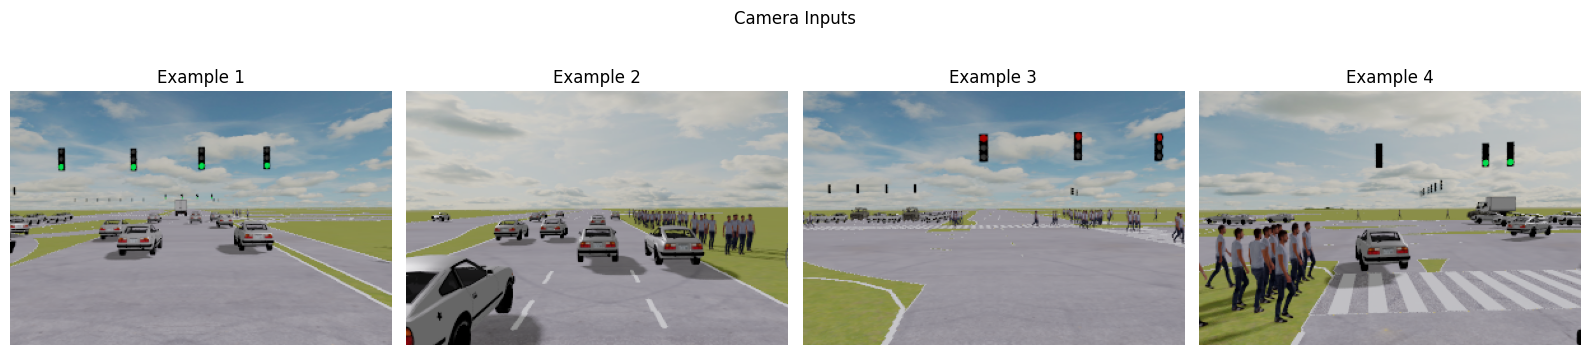

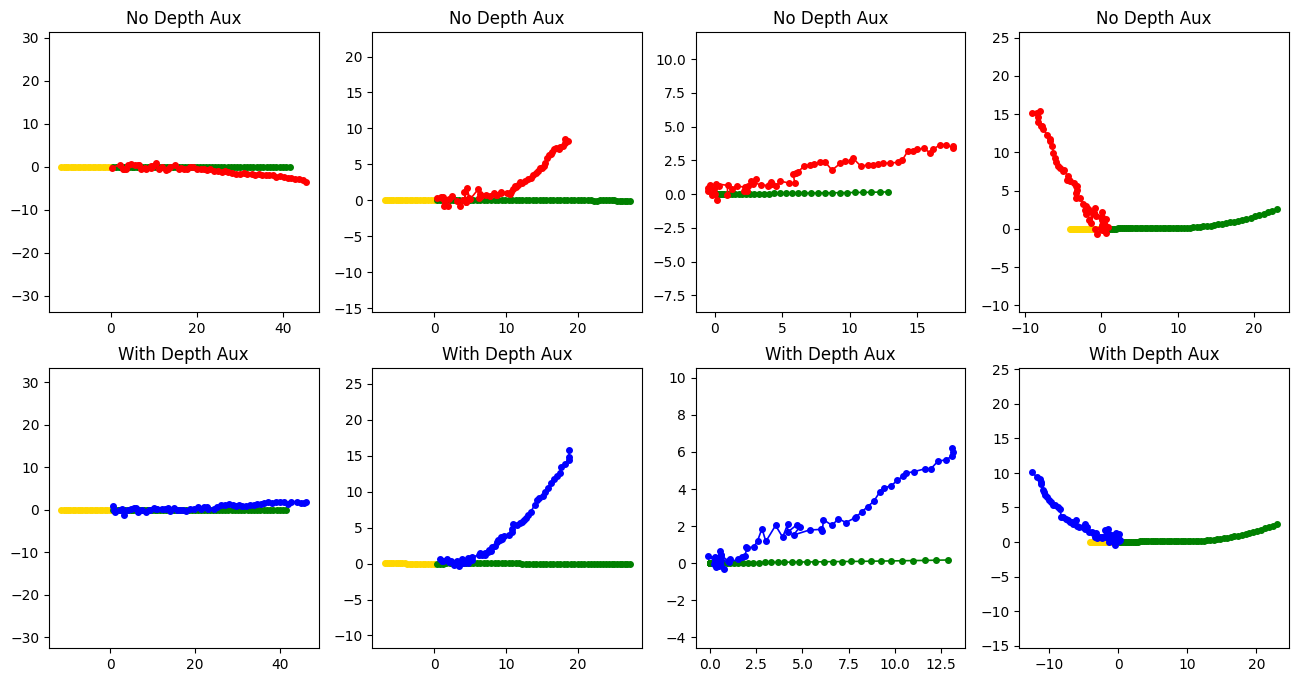

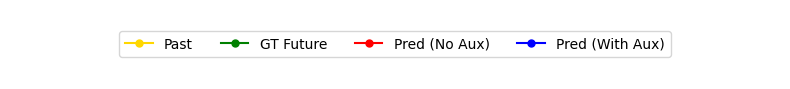

<Figure size 640x480 with 0 Axes>

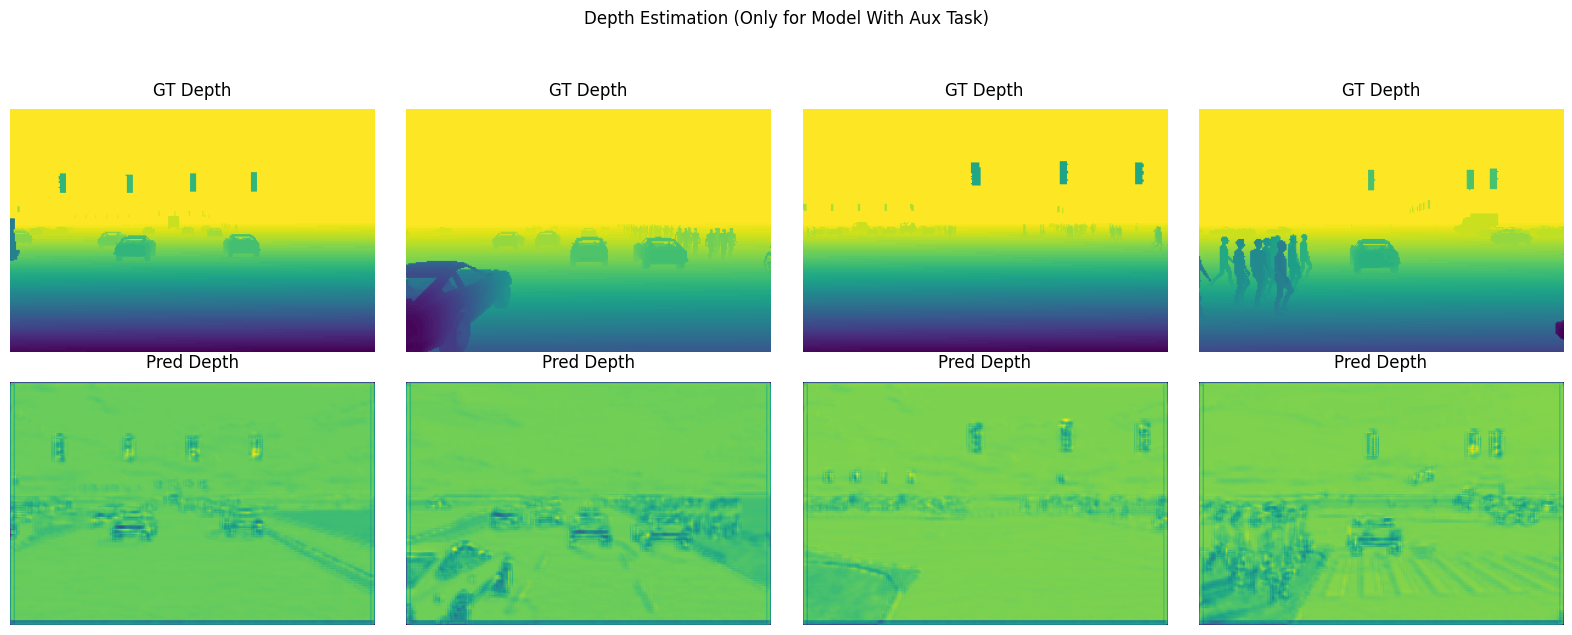

In [13]:
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model_no_aux, model_with_aux, device):
    model_no_aux.eval()
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)

    with torch.no_grad():
        pred_no_aux, _ = model_no_aux(camera, history)
        pred_with_aux, pred_depth = model_with_aux(camera, history)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_no_aux = pred_no_aux.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='Pred (No Aux)', color='red', markersize=4, linewidth=1.2)
        ax[0, i].set_title("No Depth Aux")
        ax[0, i].axis("equal")

        # With aux
        ax[1, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[1, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[1, i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[1, i].set_title("With Depth Aux")
        ax[1, i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()


# 🔚 Call at the end after training both models
visualize_comparison(val_loader, model_no_aux, model_with_aux, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(os.path.join("data", "phase2", "test_public", "0.pkl"), "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [19]:
import pandas as pd
test_data_dir = os.path.join("data", "phase2", "test_public")
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250)
model_with_aux.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future, _ = model_with_aux(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

file_name = "submission.csv"
# Save to CSV
if not os.path.exists("submission/phase2"):
    os.makedirs("submission/phase2")
df_xy.to_csv(os.path.join("submission", "phase2", file_name), index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
